## Control of DC Motor using Python control Library

In [98]:

%matplotlib inline
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as plt

import control as ct

### Define the machine parameters of a DC machine 

In [99]:
#Normalization of Sep Excited DC machine parameters
Pr = 22e3 #Watts Nominal power
Var = 400.0  #Nominal Voltage
Iar = 54.0 #Nominal Current
Nr = 3000.0 #rpm
Ra = 0.2178 #ohm
La = 3.4e-3 #H
J = 243.63 #kgm^2
#angular scale
wr = 2*np.pi*3000/60.0
mr = Var*Iar/wr
Isc = Var/Ra
Msc = mr*Isc/Iar
ra = Ra*Iar/Var
la = wr*La*Iar/Var
ta = la/ra
tj = J*wr/mr #calculation of the inertial time constant
tm = ra*tj   
print(ra,la, ta, mr, tm, tj)
# print(Isc, Iar)
#New machine definition
#ra normalize
#Ta = La/Ra
#Tj = seconds
mach_DCnew = {'ra':0.0294,'la':la, 'Ta' : ta, 'Tj':tj}


0.029403 0.1441991027997715 4.904230956017124 68.75493541569878 32.731688041731616 1113.2091297395373


In [100]:
import handcalcs.render

In [101]:
%%render 
V_ar = 400.0#V
I_ar = 54#A
R_a = 0.2178 #ohm
Z_b = V_ar/I_ar#ohms
r_a = R_a/Z_b

<IPython.core.display.Latex object>

In [102]:
#normalized parameters of a DC machines
mach_DC = {'ra': 0.0294, 'la':0.1442,'tj': 199.755  } #dictionary 
mach_DCss = {'ra': 0.0294, 'la':0.1442,'tj': 50.755  }
mach_DCs = {'ra': 0.0294, 'la':0.1442,'tj': 100.55  }
mach_DCM1 = {'ra': 0.0294, 'la':0.1442, 'tj': 5.862}# in notes 
mach_DCM4ta = {'ra': 0.0294, 'la':0.1442, 'tj': tj} #machine which Tm > 4Ta
def mach_paraDC(mach_dict):
    ra = mach_dict['ra']
    la = mach_dict['la']
    ta = la/ra
    tm = mach_dict['tj']
    return ra,la,ta,tm

#
def mach_paraDC2(mach_dict):
    ra = mach_dict['ra']
    Ta = mach_dict['Ta']
    Tj = mach_dict['Tj']
    return ra,ta,tj

In [103]:
ra,la,ta,tx = mach_paraDC(mach_DCM4ta)
print(ta,ra,tx)
ra,la,Ta,Tj = mach_paraDC(mach_DCM1)
Tm = Tj*ra
print(ra,Ta,Tj,Tm)

4.904761904761905 0.0294 1113.2091297395373
0.0294 4.904761904761905 5.862 0.1723428


### Dynamic equations for a Separately Excited DC machine
We will you normalized equations for the DC motor. The normalization process has been described above. We will assume that the flux is constant and hence we will neglect the dynamics of the field excitation winding. 

The armature voltage equation can be written as 

\begin{align}
v_a & = r_ai_a + l_a\frac{di_a}{d\tau} + \frac{d\psi_f}{d\tau}\\
v_a & = r_ai_a + l_a\frac{di_a}{d\tau} + \omega\psi_f \\
\frac{di_a}{d\tau} &= -\frac{1}{\tau_a}i_a - \frac{\omega\psi_f}{l_a} + \frac{v_a}{l_a}\\
\frac{di_a}{d\tau} &= -\frac{1}{\tau_a}i_a + \frac{v_a - v_i}{l_a}
\end{align}

We can write the mechanical dynamics as 
\begin{align}
m_e & = \psi_fi_a\\
\frac{d\omega}{d\tau} &= \frac{m_e - m_L}{\tau_m}
\end{align}

Simplified equations

\begin{align}
\frac{di_a}{dt}&= -\frac{1}{T_a}i_a + \frac{1}{l_a}(v_a - \omega)\\
\frac{d\omega}{dt} &= \frac{i_a - m_L}{T_j}
\end{align}


## Transferfunctions 
\begin{equation}\label{eq:currentTF}
    i_a(s)=\frac{sT_j}{(s^2T_mT_a+sT_m+1)}v_a(s)+\frac{1}{(s^2T_mT_a+sT_m+1)}m_L(s)
\end{equation}

and 

\begin{equation}\label{eq:speedTF}
    \omega(s)=\frac{1}{(s^2T_mT_a+sT_m+1)}v_a(s)-\frac{(sT_a+1)r_a}{(s^2T_mT_a+sT_m+1)}m_L(s)
\end{equation}

In [104]:
Tm = Tj*ra
den = [1, 1/Ta , 1/(Tm*Ta)]
numiava = [Tj,0]
numiaml = [1]
numwsva = [1]
numwsml = -ra*np.array([Ta,1])
print(den)

[1, 0.20388349514563106, 1.1830113886140359]


#### Defining the transfer functions for SE DC motor

In [105]:
Giv = ct.tf(numiava,den)
print(Giv)


       5.862 s
----------------------
s^2 + 0.2039 s + 1.183



### Step Response

In [106]:
t,y = ct.step_response(Giv)

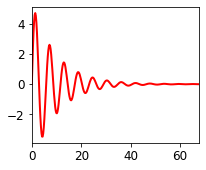

In [107]:
plt.figure(101,figsize = (3,2.5))
plt.rc('font', size = 12)
plt.plot(t,y,'r',lw =2)
plt.xlim(t[0],t[-1])

In [108]:
Gmag,Gphase,Gomega = ct.bode_plot(Giv,plot = False, wrap_phase = True)

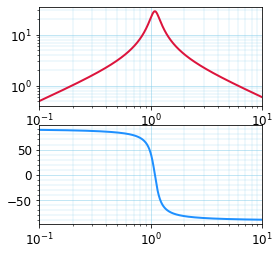

In [109]:
plt.figure(102, figsize = (4,4))
plt.subplot(2,1,1)
plt.loglog(Gomega,Gmag, 'crimson', lw = 2)
plt.xlim(Gomega[0],Gomega[-1])
plt.minorticks_on()
plt.grid(which = 'major', lw = 0.5, c = 'skyblue')
plt.grid(which = 'minor', lw = 0.25, c = 'skyblue')

plt.subplot(2,1,2)
plt.semilogx(Gomega,Gphase*180/np.pi, 'dodgerblue', lw = 2)
plt.xlim(Gomega[0],Gomega[-1])
plt.minorticks_on()
plt.grid(which = 'major', lw = 0.5, c = 'skyblue')
plt.grid(which = 'minor', lw = 0.25, c = 'skyblue')

### Step response for speed

In [110]:
Gwv = ct.tf([1],den)
print(Gwv)


          1
----------------------
s^2 + 0.2039 s + 1.183



In [111]:
tw,yw = ct.step_response(Gwv)

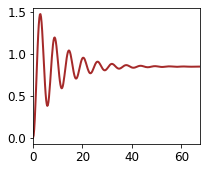

In [112]:
plt.figure(103,figsize = (3,2.5))
plt.rc('font', size = 12)
plt.plot(tw,yw,'brown',lw =2)
plt.xlim(tw[0],tw[-1])

#### Bode plot for speed vs voltage

In [113]:
Gmag2,Gphase2,Gomega2 = ct.bode_plot(Gwv,plot = False, wrap_phase = True)

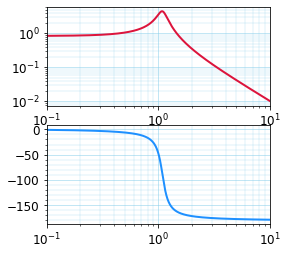

In [114]:
plt.figure(104, figsize = (4,4))
plt.subplot(2,1,1)
plt.loglog(Gomega2,Gmag2, 'crimson', lw = 2)
plt.xlim(Gomega2[0],Gomega2[-1])
plt.minorticks_on()
plt.grid(which = 'major', lw = 0.5, c = 'skyblue')
plt.grid(which = 'minor', lw = 0.25, c = 'skyblue')

plt.subplot(2,1,2)
plt.semilogx(Gomega2,Gphase2*180/np.pi, 'dodgerblue', lw = 2)
plt.xlim(Gomega2[0],Gomega2[-1])
plt.minorticks_on()
plt.grid(which = 'major', lw = 0.5, c = 'skyblue')
plt.grid(which = 'minor', lw = 0.25, c = 'skyblue')

In [115]:
pia = ct.poles(Giv)
print(pia)

[-0.10194175+1.08287546j -0.10194175-1.08287546j]


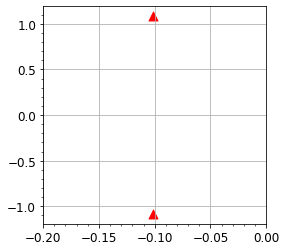

In [116]:
plt.figure(105, figsize = (4,4))
plt.rc('font', size = 12)
plt.scatter(pia.real, pia.imag, marker = "^",s = 80, c = 'r')
plt.xlim(-0.2,0.0)
plt.minorticks_on()
plt.grid()

In [117]:
#function which calculates the derivatives of the system equation
#dx/dt
#X is vector consisting of 2 state variables X[0] = ia, X[1] = w
def DCModel(X,t,paramsdc):
    x0 = X[0] #ia
    x1 = X[1] #w
    
    psf,ml,va, ta,tj = paramsdc
    me = x0*psf
    # diffs - right hand side of the differential equation that describe the system
    dx0dt = -(1/ta)*x0 - x1*psf/(la) + va/(la)
    dx1dt = (me - ml)/tj
    return [dx0dt,dx1dt]

### Voltage step response of the DC machine
In this part we will apply a voltage step and simulate the dynamics to see how the speed and the current change. We will also create a load torque step, which acts as a disturbance, on the system and see how the response is on the speed

In [118]:
tstart = 0
tend = 0.2*wr
# tend = 100.0
tinc = 0.01 #Time step - critical parameter - determines the accuracy of simuation. 
ts = np.arange(tstart,tend,tinc)

#some arrays to store the resukt
sol = np.zeros((len(ts),2)) #array that has of lenth equal to time series x 2 state variables-  X 
iaref = np.zeros(len(ts))  #array of length equal to time series 
ia = np.zeros(len(ts))
w = np.zeros(len(ts))
eia = np.zeros(len(ts))
# Initial conditions
w0 = 0.0 
ml = np.zeros(len(ts))
v = np.zeros(len(ts))
#creating a voltage steps or voltage signals 

for ii in range(len(ts)):
    if (ts[ii]>20):
        v[ii] = 1.0            #voltage remains same
        ml[ii] = 0.0           #load torque step 
    elif (ts[ii]>=0.15):
        v[ii] = 0.0           #voltage step 
    else:
        v[ii] = 0              #initial voltage

In [119]:
print(tm)

32.731688041731616


#### Define input out system format 

In [120]:
Cia_io = ct.ss2io(Giv, name = 'current_res')

In [121]:
Cia_io

<LinearIOSystem:current_res:['u[0]']->['y[0]']>

In [122]:
Cia_io.noutputs

In [123]:
tx,currentvolt =  ct.input_output_response(Cia_io,ts,v)

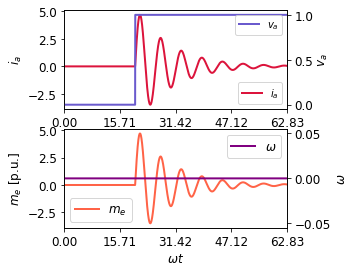

In [124]:
# dirfig = "D:/tex/lec/drives/figures/"
# dirfig2 = "D:/tex/lec/drives/Drivesbook/figures/"

plt.figure(207, figsize=(4,4))
plt.rc('font',size = 12)
ax1=plt.subplot(2,1,1)
ax1.plot(ts,currentvolt, 'crimson', lw =2, label = r"$i_a$")
ax1.set_ylabel('$i_a$')
# ax1.set_yticks(np.linspace(-0.5,0.5,5))
ax2 = ax1.twinx()
ax2.plot(ts,v, 'slateblue', lw =2, label = r"$v_a$")
ax2.set_ylabel('$v_a$')
ax2.set_xticks(np.linspace(tstart, tend,5))
ax2.set_xlim(tstart,tend)
ax1.legend(loc= "lower right", fontsize = 10)
ax2.legend(loc= "upper right", fontsize = 10)
# ax2.set_yticks(np.linspace(-0.02,0.02,5))

ax3 = plt.subplot(2,1,2)
ax3.plot(ts,currentvolt, 'tomato', lw =2, label = '$m_e$')
ax3.set_ylabel('$m_e$ [p.u.]')
ax4 = ax3.twinx()
ax4.plot(ts,w, 'purple', lw =2, label = "$\omega$")
ax4.set_ylabel('$\omega$')
ax4.set_xticks(np.linspace(tstart, tend,5))
ax3.set_xlim(tstart,tend)
ax3.set_xlabel('$\omega t$')
ax3.legend(loc = 'lower left')
ax4.legend(loc = 'upper right')
# plt.savefig(dirfig2 + 'Voltagestepresponse.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

In [125]:
#Torque disturbance

# tstart = 0
# tend = 0.5
# tinc = 0.01
# ts = np.arange(tstart,tend,tinc)

sol = np.zeros((len(ts),2))
iaref = np.zeros(len(ts))
ia = np.zeros(len(ts))
w = np.zeros(len(ts))
eia = np.zeros(len(ts))
w0 = 0.1115
ml = np.zeros(len(ts))
v = np.zeros(len(ts))
for ii in range(len(ts)):
    if (ts[ii]>30):
        v[ii] = 0.1            #voltage remains same
        ml[ii] = 0.3           #load torque step 
    elif (ts[ii]>=0.05):
        v[ii] = 0.1           #voltage step 
    else:
        v[ii] = 0.1              #initial voltage
        
psf = 1.0
kp = 5e-1
# Ti = 3.0e2
# uplim = 1.0
# dwnlim = -1.0
# Kparams = [kp,Ti,uplim,dwnlim]
ia0 = 0
x0 = [ia0,w0]
for ii in range(len(ts)):
#     if (ii > 0): 
#         eia[ii] = iaref[ii] - ia[ii-1]
#         PIea = [eia[ii], eia[ii-1]]
#         v[ii] = PIconwithLim(PIea,v[ii-1],tinc,Kparams)
    ra,la,Ta,Tj = mach_paraDC(mach_DCM1)
    paramsdc = [psf,ml[ii],v[ii],Ta,Tj]
    solx = odeint(DCModel, x0, [0,tinc], args = (paramsdc,),)  #Calling Odeint function from Scipy
    sol[ii] = solx[-1]   #Saving last result in the solution array
    x0 = solx[-1]        #re-initializing for next iteration 
    ia[ii] = sol[ii][0]  #saving results in array
    w[ii] = sol[ii][1]   #saving results in array
    
# Torque calculation
me = psf*ia

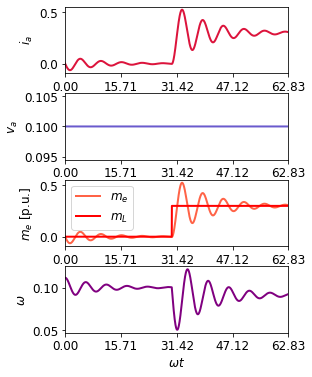

In [126]:
plt.figure(205, figsize=(4,6))
plt.rc('font',size = 12)
plt.subplots_adjust(hspace = .3)
ax1=plt.subplot(4,1,1)
ax1.plot(ts,ia, 'crimson', lw =2)
ax1.set_ylabel('$i_a$')
ax1.set_xticks(np.linspace(tstart, tend,5))
ax1.set_xlim(tstart,tend)
# ax1.set_yticks(np.linspace(-0.5,0.5,5))
ax2 = plt.subplot(4,1,2)
ax2.plot(ts,v, 'slateblue', lw =2)
ax2.set_ylabel('$v_a$')
ax2.set_xticks(np.linspace(tstart, tend,5))
ax2.set_xlim(tstart,tend)
# ax2.set_yticks(np.linspace(-0.02,0.02,5))

ax3 = plt.subplot(4,1,3)
ax3.plot(ts,me, 'tomato', lw =2, label = '$m_e$')
ax3.plot(ts,ml, 'red', lw =2, label = '$m_L$')
ax3.set_ylabel('$m_e$ [p.u.]')
ax3.set_xticks(np.linspace(tstart, tend,5))
ax3.set_xlim(tstart,tend)
ax3.legend(loc = 'upper left', fontsize = 12)
ax4 = plt.subplot(4,1,4)
ax4.plot(ts,w, 'purple', lw =2)
ax4.set_ylabel('$\omega$')
ax4.set_xticks(np.linspace(tstart, tend,5))
ax4.set_xlim(tstart,tend)
ax4.set_xlabel('$\omega t$')
# ax4.legend(loc = 'lower left')
# dirfig = "D:/tex/lec/drives/figures/"
# plt.savefig(dirfig+'LoadTorqueresponseDCM1.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

### machine with tm > 4ta

In [127]:
# tstart = 0
# tend = 0.5*wr
# tinc = 0.01
# ts = np.arange(tstart,tend,tinc)

sol = np.zeros((len(ts),2))
iaref = np.zeros(len(ts))
ia = np.zeros(len(ts))
w = np.zeros(len(ts))
eia = np.zeros(len(ts))
w0 = 0.0
ml = np.zeros(len(ts))
v = np.zeros(len(ts))
for ii in range(len(ts)):
    if (ts[ii]>40):
        v[ii] = -1.0            #voltage remains same
        ml[ii] = 0.0           #load torque step 
    elif (ts[ii]>=0.15):
        v[ii] = 1.0           #voltage step 
    else:
        v[ii] = 0              #initial voltage
        
psf = 1.0
# kp = 5e-1
# Ti = 3.0e2
# uplim = 1.0
# dwnlim = -1.0
# Kparams = [kp,Ti,uplim,dwnlim]

x0 = [0,w0]
for ii in range(len(ts)):
    ra,Ta,Tj = mach_paraDC2(mach_DCnew)
    paramsdc = [psf,ml[ii],v[ii],Ta,Tj]
    solx = odeint(DCModel, x0, [0,tinc], args = (paramsdc,),)  #Calling Odeint function from Scipy
    sol[ii] = solx[-1]   #Saving last result in the solution array
    x0 = solx[-1]        #re-initializing for next iteration 
    ia[ii] = sol[ii][0]  #saving results in array
    w[ii] = sol[ii][1]   #saving results in array
    
# Torque calculation
me = psf*ia

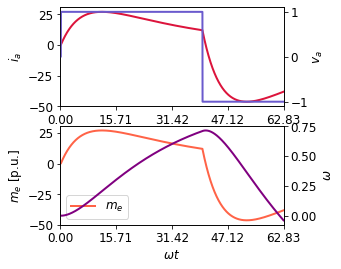

In [128]:
plt.figure(201, figsize=(4,4))
plt.rc('font',size = 12)
ax1=plt.subplot(2,1,1)
ax1.plot(ts,ia, 'crimson', lw =2)
ax1.set_ylabel('$i_a$')
# ax1.set_yticks(np.linspace(-0.5,0.5,5))
ax2 = ax1.twinx()
ax2.plot(ts,v, 'slateblue', lw =2)
ax2.set_ylabel('$v_a$')
ax2.set_xticks(np.linspace(tstart, tend,5))
ax2.set_xlim(tstart,tend)
# ax2.set_yticks(np.linspace(-0.02,0.02,5))

ax3 = plt.subplot(2,1,2)
ax3.plot(ts,me, 'tomato', lw =2, label = '$m_e$')
ax3.set_ylabel('$m_e$ [p.u.]')
ax4 = ax3.twinx()
ax4.plot(ts,w, 'purple', lw =2)
ax4.set_ylabel('$\omega$')
ax4.set_xticks(np.linspace(tstart, tend,5))
ax3.set_xlim(tstart,tend)
ax3.set_xlabel('$\omega t$')
ax3.legend(loc = 'lower left')
# pl.savefig('VoltagestepresponseDCM4ta.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

In [129]:
#Torque disturbance

# tstart = 0
# tend = 0.5*wr
# tinc = 0.01
# ts = np.arange(tstart,tend,tinc)

sol = np.zeros((len(ts),2))
iaref = np.zeros(len(ts))
ia = np.zeros(len(ts))
w = np.zeros(len(ts))
eia = np.zeros(len(ts))
w0 = 0.1125
ml = np.zeros(len(ts))
v = np.zeros(len(ts))
for ii in range(len(ts)):
    if (ts[ii]>40):
        v[ii] = 0.1            #voltage remains same
        ml[ii] = 0.3           #load torque step 
    elif (ts[ii]>=0.05):
        v[ii] = 0.1           #voltage step 
    else:
        v[ii] = 0.1              #initial voltage
        
psf = 0.9
kp = 5e-1
Ti = 3.0e2
uplim = 1.0
dwnlim = -1.0
Kparams = [kp,Ti,uplim,dwnlim]
ia0 = 0
x0 = [ia0,w0]
for ii in range(len(ts)):
#     if (ii > 0): 
#         eia[ii] = iaref[ii] - ia[ii-1]
#         PIea = [eia[ii], eia[ii-1]]
#         v[ii] = PIconwithLim(PIea,v[ii-1],tinc,Kparams)
    ra,Ta,Tj = mach_paraDC2(mach_DCnew)
    paramsdc = [psf,ml[ii],v[ii],Ta,Tj]
    solx = odeint(DCModel, x0, [0,tinc], args = (paramsdc,),)  #Calling Odeint function from Scipy
    sol[ii] = solx[-1]   #Saving last result in the solution array
    x0 = solx[-1]        #re-initializing for next iteration 
    ia[ii] = sol[ii][0]  #saving results in array
    w[ii] = sol[ii][1]   #saving results in array
    
# Torque calculation
me = psf*ia

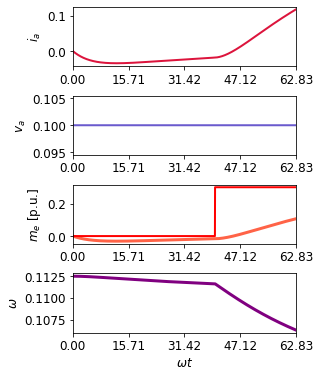

In [130]:
plt.figure(202, figsize=(4,6))
plt.rc('font',size = 12)
plt.subplots_adjust(hspace = .5)
ax1=plt.subplot(4,1,1)
ax1.plot(ts,ia, 'crimson', lw =2)
ax1.set_ylabel('$i_a$')
ax1.set_xticks(np.linspace(tstart, tend,5))
ax1.set_xlim(tstart,tend)
# ax1.set_yticks(np.linspace(-0.5,0.5,5))
ax2 = plt.subplot(4,1,2)
ax2.plot(ts,v, 'slateblue', lw =2)
ax2.set_ylabel('$v_a$')
ax2.set_xticks(np.linspace(tstart, tend,5))
ax2.set_xlim(tstart,tend)
# ax2.set_yticks(np.linspace(-0.02,0.02,5))

ax3 = plt.subplot(4,1,3)
ax3.plot(ts,me, 'tomato', lw =3, label = '$m_e$')
ax3.plot(ts,ml, 'red', lw =2, label = '$m_L$')
ax3.set_ylabel('$m_e$ [p.u.]')
ax3.set_xticks(np.linspace(tstart, tend,5))
ax3.set_xlim(tstart,tend)
ax4 = plt.subplot(4,1,4)
ax4.plot(ts,w, 'purple', lw =3)
ax4.set_ylabel('$\omega$')
ax4.set_xticks(np.linspace(tstart, tend,5))
ax4.set_xlim(tstart,tend)
ax4.set_xlabel('$\omega t$')
# ax4.legend(loc = 'lower left')
# pl.savefig('LoadTorqueresponseDCM4ta.pdf', bbox_inches = 'tight', transparent = True)
plt.show()

In [131]:

# ra,la,ta,txx = mach_paraDC(mach_DCM4ta) 
# tm = txx
ra,ta,tm = mach_paraDC2(mach_DCnew)
# tm = tj
# ra,la,ta,tm = mach_paraDC(mach_DCss)
# ra,la,ta,tm = mach_paraDC(mach_DCM1)
#Transfer functions
# ia/va
numiava = [tm/ra, 0]
deniav = [tm*ta, tm, 1 ]
numwa = [1]
print(ta,4*ta,tm,tm/ra)

4.904761904761905 19.61904761904762 1113.2091297395373 37864.256113589705


In [132]:
from scipy import signal
import sympy as sy

sy.init_printing()  # LaTeX like pretty printing for IPython
s = sy.Symbol('s')


def lti_to_sympy(lsys, symplify=True):
    """ Convert Scipy's LTI instance to Sympy expression """
    s = sy.Symbol('s')
    G = sy.Poly(lsys.num, s) / sy.Poly(lsys.den, s)
    return sy.simplify(G) if symplify else G


def sympy_to_lti(xpr, s=sy.Symbol('s')):
    """ Convert Sympy transfer function polynomial to Scipy LTI """
    num, den = sy.simplify(xpr).as_numer_denom()  # expressions
    p_num_den = sy.poly(num, s), sy.poly(den, s)  # polynomials
    c_num_den = [sy.Poly(p).all_coeffs() for p in p_num_den]  # coefficients
    l_num, l_den = [sy.lambdify((), c)() for c in c_num_den]  # convert to floats
    return signal.lti(l_num, l_den)


pG, pH, pGH, pIGH = sy.symbols("G, H, GH, IGH")  # only needed for displaying


# Sample systems:
lti_G = signal.lti([1], [1, 2])
lti_H = signal.lti([2], [1, 0, 3])

# convert to Sympy:
# Gs, Hs = lti_to_sympy(lti_G), lti_to_sympy(lti_H)
# display(Gs)
# display(Hs)
# Gwvadis = lti_to_sympy(Gwva)
# display(Gwvadis)

In [133]:
ra,la,ta,tm = mach_paraDC(mach_DCM4ta)
# ra,la,ta,tm = mach_paraDC(mach_DCnew)
tj = tm/ra
# ra,la,ta,tm = mach_paraDC(mach_DCss)
# ra,la,ta,tm = mach_paraDC(mach_DCM1)
#Transfer functions
numiava = [tj, 0]
deniav = [tm*ta, tm, 1 ]
numwa = [1]

In [134]:
Gia2 = ct.tf(numiava,deniav)
print(Gia2)


     3.786e+04 s
---------------------
5460 s^2 + 1113 s + 1



In [135]:
px1 = ct.poles(Gia2)
zx1 = ct.zeros(Gia2)
print('zeros of the system', zx1)
print('poles of the system', px1)

zeros of the system [0.+0.j]
poles of the system [-0.2029812+0.j -0.0009023+0.j]


In [136]:
# Poles of the transfer functions 
ppx = signal.tf2zpk(numiava, deniav)
zx,px,kx = signal.tf2zpk(numiava,deniav)
print('zeros of the system', zx)
print('poles of the system', px)
print('gain of the system', kx)
print(ppx)

zeros of the system [0.]
poles of the system [-0.2029812 -0.0009023]
gain of the system 6.934812760055479
(array([0.]), array([-0.2029812, -0.0009023]), 6.934812760055479)


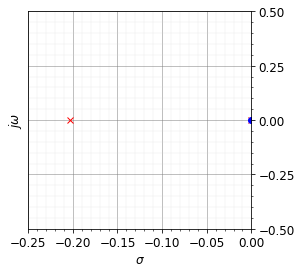

In [137]:
#Step response
# yia = signal.lti.step(Giv)
# pl.figure(301,figsize = (4,3))
# pl.rc('font', size =14)
# pl.plot(yia[0],yia[1], 'red', lw =2)
# print(np.size(yia))

plt.figure(302,figsize = (4,4))
plt.rc('font', size =12)
ax =plt.subplot(111)
ax.yaxis.tick_right()
# ax.plot(ppx[1][0].real,ppx[1][0].imag, 'rx')
# ax.plot(ppx[1][1].real,ppx[1][1].imag, 'bx')
ax.plot(ppx[1].real,ppx[1].imag, 'rx')
ax.plot(ppx[0].real,ppx[0].imag,'bo')
ax.set_xlim(-0.25,xmax=0)
ax.minorticks_on()
ax.set_yticks(np.linspace(-0.5,0.5,5))
# pl.axhline(0, c = 'k')
plt.xlabel('$\sigma$')
ax.set_ylabel('$j\omega$')
plt.grid(True, which = 'major', lw =0.5, c = 'grey')
plt.grid(True, which = 'minor', lw =0.2, c = 'lightgrey')
# pl.text(ppx[1][0]-0.05,-0.15, "$s_1 = ${0:0.3f}".format(ppx[1][0]))
# pl.text(ppx[1][1]-0.05, 0.15, "$s_2 = ${0:0.3f}".format(ppx[1][1]))

# plt.savefig("poleplotDC4ta.pdf", bbox_inches = 'tight', transparent = True)
plt.show()

In [138]:
Ts = -1/ppx[1][0]
Tl = -1/ppx[1][1]

print(Ts,Tl)

4.92656467193145 1108.2825650676057


In [139]:
#Transfer function ia/va Giv
Giv = signal.lti(numiava, deniav)
DGiv = lti_to_sympy(Giv)
print(Giv.num)
print(Giv.den)
print(DGiv)

[6.93481276 0.        ]
[1.00000000e+00 2.03883495e-01 1.83149320e-04]
6.93481276005548*s/(1.0*s**2 + 0.203883495145631*s + 0.000183149320014412)


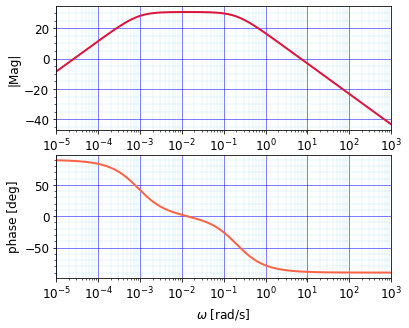

In [140]:
#Open loop transfer function 

# w = np.arange(0.001,10e5,0.1)
w = np.logspace(-5,3,1000)
wiv,magiv, phaseiv = signal.bode(Giv,w)
plt.figure(401,figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.semilogx(w,magiv, 'crimson', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlim(w[0],w[-1])
plt.ylabel("|Mag|")

plt.subplot(2,1,2)
plt.semilogx(w,phaseiv, 'tomato', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlabel('$\omega$ [rad/s]')
plt.xlim(w[0],w[-1])
plt.ylabel("phase [deg]")
# plt.savefig(dirfig2+"CurrentForwardBode.pdf", bbox_inches = 'tight', transparent = True)
plt.show()

In [141]:
#Current transfer function 
Giv
# display(DGiv)
zx,px,kx = signal.tf2zpk(numiava,deniav)
print('zeros of the system', zx)
print('poles of the system', px)
print('gain of the system', kx)
#Pi Transfer function
Ti = Tl
kpa = Tl/(2*kx*Ts)
numPIpoly = np.array([Ti,1])
denPI = np.array([Ti,0])
numPI = kpa*numPIpoly
GPIc = signal.lti(numPI,denPI)
print(Tl,Ts)

zeros of the system [0.]
poles of the system [-0.2029812 -0.0009023]
gain of the system 6.934812760055479
1108.2825650676057 4.92656467193145


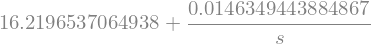

TransferFunctionContinuous(
array([1.12480261e+02, 1.01490599e-01]),
array([1.00000000e+00, 2.03883495e-01, 1.83149320e-04]),
dt: None
)
112.480261487474*s + 0.10149059908798 1.0*s**2 + 0.203883495145631*s + 0.000183149320014412
(Poly(112.480261487474*s + 0.10149059908798, s, domain='RR'), Poly(1.0*s**2 + 0.203883495145631*s + 0.000183149320014412, s, domain='RR'))


In [142]:
DGPIc = lti_to_sympy(GPIc)
display(DGPIc)
DGOIV = DGPIc*DGiv
DGCiv = DGOIV/(1 + DGOIV)
Goiv = sympy_to_lti(DGOIV)
Gciv = sympy_to_lti(DGCiv)
print(Goiv)
xpr = DGOIV
num, den = sy.simplify(xpr).as_numer_denom()  # expressions
p_num_den = sy.poly(num, s), sy.poly(den, s)  # polynomials
print(num,den)
print(p_num_den)

In [143]:
numoiv = np.array([19.3098, 0.09936873])
denoiv = np.array([1.0, 0.203883495, 0.001022706])
zoiv,poiv,koiv = signal.tf2zpk(numoiv,denoiv)
print('zeros of the Goiv', zoiv)
print('poles of the Goiv', poiv)
print('gain of the Goiv', koiv)

zeros of the Goiv [-0.00514603]
poles of the Goiv [-0.19873748 -0.00514601]
gain of the Goiv 19.3098


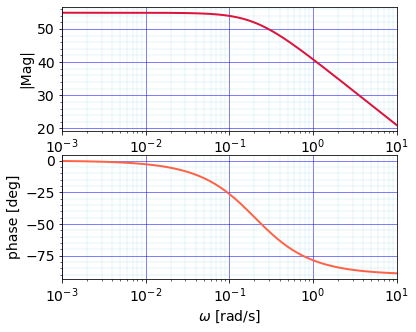

In [144]:
#Open loop transfer function with inner PI Controller

w = np.logspace(-3,1,200)
wo,magov, phaseo = signal.bode(Goiv,w)
plt.figure(401,figsize = (6,5))
plt.rc('font', size = 14)
plt.subplot(2,1,1)
plt.semilogx(wo,magov, 'crimson', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlim(w[0],w[-1])
plt.ylabel("|Mag|")
plt.subplot(2,1,2)
plt.semilogx(wo,phaseo, 'tomato', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlabel('$\omega$ [rad/s]')
plt.xlim(w[0],w[-1])
plt.ylabel("phase [deg]")
# plt.savefig(dirfig2+"CurrentOpenloopPIbode.pdf", bbox_inches= 'tight', transparent = True)
plt.show()

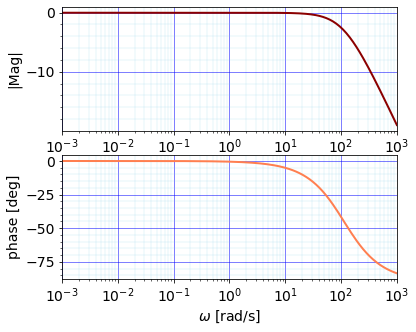

In [145]:
#Closed loop transfer function with inner PI Controller
w = np.logspace(-3,3,200)
wc,magcv, phasec = signal.bode(Gciv,w)
plt.figure(402,figsize = (6,5))
plt.rc('font', size = 14)
plt.subplot(2,1,1)
plt.semilogx(wc,magcv, 'darkred', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlim(w[0],w[-1])
plt.ylabel("|Mag|")

plt.subplot(2,1,2)
plt.semilogx(wc,phasec, 'coral', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel("phase [deg]")
plt.xlim(w[0],w[-1])
# plt.savefig(dirfig2+"CurrentCloseloopPIbode.pdf", bbox_inches= 'tight', transparent = True)
plt.show()

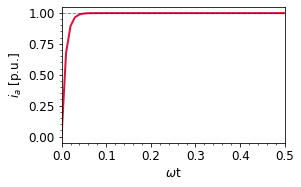

In [146]:
#Step response
yciv = signal.lti.step(Gciv, T = ts)
plt.figure(301,figsize = (4,2.5))
plt.rc('font', size =12)
plt.plot(yciv[0],yciv[1], 'crimson', lw =2)
plt.minorticks_on()
# plt.grid(True, which = 'major', lw =0.5, c = 'blue')
# plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.axhline(1.0,ls = "-.", c = 'b', lw = 0.5)
# plt.xticks(np.linspace(0,1.6,5))
plt.xlim(0,0.5)
plt.xlabel('$\omega$t')
plt.ylabel(r"$i_a$ [p.u.]")
# plt.savefig(dirfig2+"StepResponseInnerCurrent.pdf", bbox_inches = 'tight', transparent = True)

plt.show()


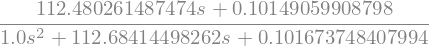

Te= 0.00887, ke = 0.99819
37864.256113589705 0.008874362938585872 0.9981906638668869
[0.00297062]
[  1.         112.68414498   0.        ]


In [147]:
DGciv = lti_to_sympy(Gciv)
display(DGciv)
K1 = Gciv.num
Den = Gciv.den
Te = 1/Den[1]
ke = K1[0]/Den[1]
#equivalent closed loop tranfer function
tnum = [ke] #numerator
tden = [Te,1] #denominator
print("Te= {0:3.5f}, ke = {1:3.5f}".format(Te,ke))
TGciv = signal.lti(tnum,tden)
#Speed part 1/sTj
Gs = signal.lti(1,[tj,0])
Tdgciv = lti_to_sympy(TGciv)
TGs = lti_to_sympy(Gs)
DGsf = Tdgciv*TGs
Gsf = sympy_to_lti(DGsf)
# display(DGs)
print(tj,Te,ke)
print(Gsf.num)
print(Gsf.den)

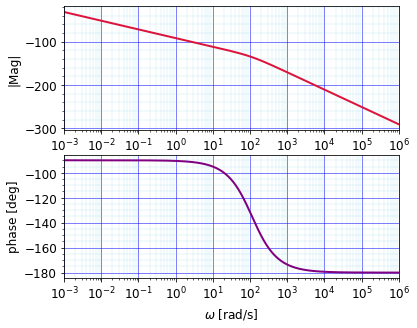

In [148]:
#Foward Speed loop
from matplotlib.ticker import AutoMinorLocator

ax1.tick_params(axis="both", direction="in", which="both", right=False, top=True)
ax2.tick_params(axis="both", direction="in", which="both", right=True, top=False)

w2 = np.logspace(-3,6,1000)
ws2, mags,phases = signal.bode(Gsf,w2)

plt.figure(403,figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.semilogx(ws2,mags, 'crimson', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlim(w2[0],w2[-1])
plt.ylabel("|Mag|")

plt.subplot(2,1,2)
plt.semilogx(ws2,phases, 'purple', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel("phase [deg]")
plt.xlim(w2[0],w2[-1])
# plt.savefig(dirfig2+"SpeedOpenLoopBode.pdf", bbox_inches= 'tight', transparent = True)
plt.show()

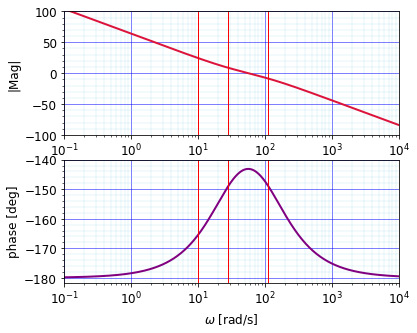

In [149]:
#Speed open loop transfer function 
a = 2.0
kps = tj/(a*ke*Te)
b1pi = Te*a**2 
numpi = [b1pi*kps,1*kps]
#Transfer function of Symmetrical optimum speed PI
GPi = signal.lti(numpi,[b1pi,0])
#For display
DGPi = lti_to_sympy(GPi)
#Multiply the sympy transfer function 
DGsos = DGsf*DGPi
#in Sympy
# display(DGsos)
#Convert back lti from sympy
Gsos = sympy_to_lti(DGsos)

#Symmetrical optimum bode plot

ws = np.logspace(-5,6,1000)
wso, magso,phaseso = signal.bode(Gsos,ws)
wlow = 1e-1
whigh = 10000
plt.figure(401,figsize = (6,5))
plt.rc('font', size = 12)
plt.subplot(2,1,1)
plt.semilogx(wso,magso, 'crimson', lw =2)
plt.axvline(10, c= 'r', lw = 1)
plt.axvline(1/(Te*a**2), c = 'r', lw =1)
plt.axvline(1/Te, c = 'r', lw = 1)
plt.yticks(np.linspace(-100,100,5))
plt.ylim(-100,100)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlim(wlow,whigh)
plt.ylabel("|Mag|")

plt.subplot(2,1,2)
plt.semilogx(wso,phaseso, 'purple', lw =2)
plt.minorticks_on()
plt.axvline(10, c = 'r', lw = 1)
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
plt.xlabel('$\omega$ [rad/s]')
plt.ylabel("phase [deg]")
plt.axvline(10, c= 'r', lw = 1)
plt.axvline(1/(Te*a**2), c = 'r', lw =1)
plt.axvline(1/Te, c = 'r', lw = 1)
# pl.xlim(wso[0],wso[-1])
plt.xlim(wlow,whigh)
plt.yticks(np.linspace(-180,-140,5))
# plt.savefig(dirfig2 +"SpeedSymmetricalPIBode.pdf", bbox_inches= 'tight', transparent = True)
plt.show()


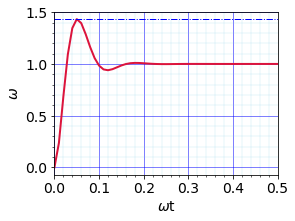

In [150]:
#Step response Symmetrical optimum
#For any arithmetic operation on transfer function use the tf in sympy
DGcos = DGsos/(1+DGsos)
#Then convert back to lti
Gcos = sympy_to_lti(DGcos)
#Step response of the closed loop transfer function 
yss = signal.lti.step(Gcos, T = ts)
#plot
plt.figure(301,figsize = (4,3))
plt.rc('font', size =14)
plt.plot(yss[0],yss[1], 'crimson', lw =2)
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.2, c = 'skyblue')
# pl.xticks(np.linspace(0,yss[0][-1],5))
plt.xlim(0,0.5)
plt.axhline(1.434, ls = "-.",c = 'b', lw = 1.0)
plt.xlabel('$\omega$t')
plt.ylabel('$\omega$')
# plt.savefig(dirfig2+"StepResponseSpeedSymmOpt.pdf", bbox_inches = 'tight', transparent = True)

plt.show()


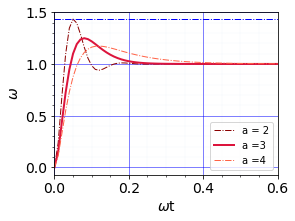

In [151]:
#Changing value of a

#Speed open loop transfer function 
a = 3.0
kps = tj/(a*ke*Te)
b1pi = Te*a**2 
numpi2 = [b1pi*kps,1*kps]
GPi2 = signal.TransferFunction(numpi2,[b1pi,0])
DGPi2 = lti_to_sympy(GPi2)
DGsos2 = DGsf*DGPi2
# display(DGsos)
Gsos2 = sympy_to_lti(DGsos2)

a = 4.0
kps = tj/(a*ke*Te)
b1pi3 = Te*a**2 
numpi3 = [b1pi3*kps,1*kps]
GPi3 = signal.TransferFunction(numpi3,[b1pi3,0])
DGPi3 = lti_to_sympy(GPi3)
DGsos3 = DGsf*DGPi3
# display(DGsos)
Gsos3 = sympy_to_lti(DGsos3)

#Step response
#Step response Symmetrical optimum
DGcos2 = DGsos2/(1+DGsos2)
Gcos2 = sympy_to_lti(DGcos2)
yss2 = signal.lti.step(Gcos2, T = ts)

DGcos3 = DGsos3/(1+DGsos3)
Gcos3 = sympy_to_lti(DGcos3)
yss3 = signal.lti.step(Gcos3, T = ts)


plt.figure(302,figsize = (4,3))
plt.rc('font', size =14)
plt.plot(yss[0],yss[1],'-.', c='darkred', lw =1, label = 'a = 2')
plt.plot(yss2[0],yss2[1], 'crimson', lw =2, label = 'a =3')
plt.plot(yss3[0],yss3[1],"-.", c=  'tomato', lw =1, label = 'a =4')
plt.minorticks_on()
plt.grid(True, which = 'major', lw =0.5, c = 'blue')
plt.grid(True, which = 'minor', lw =0.05, c = 'skyblue')
# plt.xticks(np.linspace(0,yss[0][-1],5))
plt.xlim(0,0.6)
plt.axhline(1.434,ls = "-.", c = 'b', lw = 1.0)

plt.xlabel('$\omega$t')
plt.ylabel('$\omega$')
plt.legend(loc = 'lower right', fontsize = 10)
# plt.savefig(dirfig2+"StepResponseSpeedSymmOpta3.pdf", bbox_inches = 'tight', transparent = True)
plt.show()

In [169]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)*dt
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)*dt
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

In [153]:
# Select the machine
# ra, la, ta, tm = mach_paraDC(mach_DC)
#
# ra,la,ta,txx = mach_paraDC(mach_DCM4ta)
ra,ta,tj = mach_paraDC2(mach_DCnew)
numiava = [tj, 0]
tm = tj*ra
deniav = [tm*ta, tm, 1 ]
numwa = [1]
print(ta,4*ta,tm,tj)
Giv = signal.lti(numiava, deniav)
zx, px,kx = signal.tf2zpk(Giv.num,Giv.den)
print("poles of the Giv",px)
print(kx)

Tl = -1/px[1]
Ts = -1/px[0]
print("Tl =",Tl)
print("Ts =",Ts)
Ti = Tl
kpi = Tl/(2*kx*Ts)

4.904761904761905 19.61904761904762 1113.2091297395373 37864.256113589705
poles of the Giv [-0.2029812 -0.0009023]
6.934812760055479
Tl = 1108.2825650676057
Ts = 4.92656467193145


In [154]:
# Setting the speed loop parameters
GPIc = signal.lti([kpi*Ti,kpi],[Ti,0])
DGPIc = lti_to_sympy(GPIc)
DGiv = lti_to_sympy(Giv)
DGoiv = DGiv*DGPIc
Goiv = sympy_to_lti(DGoiv)
DGciv = DGoiv/(1 + DGoiv)
Gciv = sympy_to_lti(DGciv)
numciv = Gciv.num
denciv = Gciv.den
print(numciv)
print(denciv)
Te = 1/denciv[1]
ke = numciv[0]/denciv[1]
print(Te,ke)
a = 3.0
kpw = tj/(a*ke*Te)
Tiw = Te*a**2

[1.12480261e+02 1.01490599e-01]
[1.00000000e+00 1.12684145e+02 1.01673748e-01]
0.008874362938585872 0.9981906638668869


In [165]:
tstart = 0
tend = 0.5*wr
# tend = 100.0
tinc = 0.01
ts = np.arange(tstart,tend,tinc)



sol = np.zeros((len(ts),2))
iaref = np.zeros(len(ts))
ia = np.zeros(len(ts))
w = np.zeros(len(ts))
eia = np.zeros(len(ts))
w0 = 0.0
ml = np.zeros(len(ts))
v = np.zeros(len(ts))
for ii in range(len(ts)):
    if (ts[ii]>50):
        iaref[ii] = -0.2
        ml[ii] = 0.0
    elif (ts[ii]>=0.05):
        iaref[ii] = 0.5
    else:
        iaref[ii] = 0
        
psf = 1.0
#Magnitude optimum for inner current PI-controller

uplim = 1.0
dwnlim = -1.0
KparamsL = [kpi,Ti,uplim,dwnlim]
Kparams = [kpi,Ti]
x0 = [0,w0]
for ii in range(len(ts)):
    if (ii > 0): 
        eia[ii] = iaref[ii] - ia[ii-1]
        PIea = [eia[ii], eia[ii-1]]
#         v[ii] = PIconwithLim(PIea,v[ii-1],tinc,KparamsL)
        v[ii] = PIcon(PIea,v[ii-1],tinc,Kparams)
    ra,ta,tj = mach_paraDC2(mach_DCnew)
    paramsdc = [psf,ml[ii],v[ii],ta,tj]
    solx = odeint(DCModel, x0, [0,ts[1]], args = (paramsdc,),)
    sol[ii] = solx[-1]
    x0 = solx[-1]
    ia[ii] = sol[ii][0]
    w[ii] = sol[ii][1]
    

me = psf*ia
print(kp,Ti)

500.0 30000000000.0


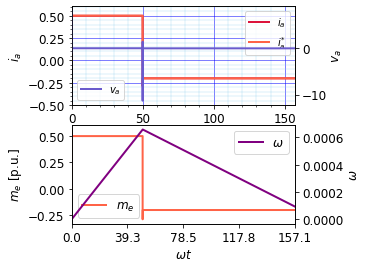

In [156]:
plt.figure(202, figsize=(4,4))
plt.rc('font',size = 12)
ax1=plt.subplot(2,1,1)
ax1.plot(ts,ia, 'crimson', lw =2, label = "$i_a$")
ax1.plot(ts,iaref,'tomato',lw=2, label = "$i^{*}_{a}$")
# ax1.set_yticks(np.linspace(-12,12,5))
# ax1.set_ylim(-12,12)
ax1.set_yticks(np.linspace(-0.5,0.5,5))
ax2 = ax1.twinx()
ax2.plot(ts,v, 'slateblue', lw =2, label = "$v_a$")
ax2.set_xlim(tstart,tend)
ax2.set_ylabel('$v_a$')
ax1.set_ylabel('$i_a$')
ax1.minorticks_on()
ax1.grid(which = 'minor',c = 'skyblue', lw = 0.3)
ax1.grid(which = 'major',c = 'blue', lw = 0.5)
ax1.legend(loc = "upper right", fontsize = 10)
ax2.legend(loc = "lower left", fontsize = 10)
# ax2.set_yticks(np.linspace(-8,8.0,5))
# ax2.set_yticks(np.linspace(-0.02,0.02,5))

ax3 = plt.subplot(2,1,2)
ax3.plot(ts,me, 'tomato', lw =2, label = '$m_e$')
ax3.set_ylabel('$m_e$ [p.u.]')
ax4 = ax3.twinx()
ax4.plot(ts,w, 'purple', lw =2, label = "$\omega$")
ax4.set_ylabel('$\omega$')
ax4.set_xticks(np.linspace(tstart, tend,5))
ax3.set_xlim(tstart,tend)
ax3.set_xlabel('$\omega t$')
ax3.legend(loc = 'lower left')
ax4.legend(loc = "upper right")
# plt.savefig(dirfig2 + "StepresponseCurrentloopwithPIlim.pdf", bbox_inches = 'tight', transparent = True)
plt.show()

### Speed Control of DC motor 

In [170]:
tend = 4*wr
tinc = 0.01
ts = np.arange(tstart,tend,tinc)

sol = np.zeros((len(ts),2))
iaref = np.zeros(len(ts))
ia = np.zeros(len(ts))
w = np.zeros(len(ts))
eia = np.zeros(len(ts))
ew = np.zeros(len(ts))
wref = np.zeros(len(ts))
w0 = 0.0
ml = np.zeros(len(ts))
v = np.zeros(len(ts))
for ii in range(len(ts)):
    if (ts[ii]>2.5*wr):
        wref[ii] = -0.2
        ml[ii] = 0.3
    elif (ts[ii]>=0.1*wr):
        wref[ii] = 0.5
    else:
        wref[ii] = 0
        
psf = 0.9
kp = 5.0e-1
Ti = 3.0e2
uplim = 1.0
dwnlim = -1.0
KparamsL = [kp,Ti,uplim,dwnlim]
Kparams = [kp,Ti]

kps = 5550
Tiw = 1e3
uplimw = 1.0
dwnlimw = -1.0
KparamswL = [kpw,Tiw,uplimw,dwnlimw]
Kparamsw = [kps,Tiw]
print(kps)
print(Te)
print(b1pi)
print(tj)

5550
0.008874362938585872
0.07986926644727285
37864.256113589705


In [171]:
x0 = [0,w0]
for ii,tn in enumerate(ts):
    if (ii > 0):
        ew[ii] = wref[ii] - w[[ii-1]]
        PIw = [ew[ii], ew[ii-1]]
#         iaref[ii] = PIconwithLim(PIw, iaref[ii-1], tinc, KparamswL)
        iaref[ii] = PIcon(PIw, iaref[ii-1], tinc, Kparamsw)
        eia[ii] = iaref[ii] - ia[ii-1]
        PIea = [eia[ii], eia[ii-1]]
#         v[ii] = PIconwithLim(PIea,v[ii-1],tinc,KparamsL)
        v[ii] = PIcon(PIea,v[ii-1],tinc,Kparams)
    ra,la,ta,tm = mach_paraDC(mach_DCM4ta)
    paramsdc = [psf,ml[ii],v[ii],ta,tm]
    solx = odeint(DCModel, x0, [0,tinc], args = (paramsdc,),)
    sol[ii] = solx[-1]
    x0 = solx[-1]
    ia[ii] = sol[ii][0]
    w[ii] = sol[ii][1]
    

me = psf*ia

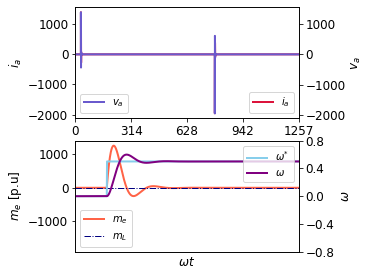

In [172]:
plt.figure(203, figsize=(4,4.5))
plt.rc('font',size = 12)
ax1=plt.subplot(2,1,1)
ax1.plot(ts,ia, 'crimson', lw =2, label = "$i_a$")
# ax1.plot(ts,iaref, 'tomato', lw =2, label = "$i^{*}_a$")
# ax1.set_yticks(np.linspace(-12,12,5))
# ax1.set_ylim(-20,20)
# ax1.set_yticks(np.linspace(-0.5,0.5,5))
ax2 = ax1.twinx()
ax2.plot(ts,v, 'slateblue', lw =2, label = "$v_a$")
ax2.set_xticks(np.linspace(tstart, tend,5))
ax2.set_xlim(tstart,tend)
ax2.set_ylabel('$v_a$')
ax1.set_ylabel('$i_a$')
ax1.legend(loc = 'lower right', fontsize =10)
plt.legend(loc = 'lower left', fontsize =10)
# ax2.set_yticks(np.linspace(-8,8.0,5))

ax3 = plt.subplot(2,1,2)
ax3.plot(ts,me, 'tomato', lw =2, label = '$m_e$')
ax3.plot(ts,ml,ls="-.",c = 'navy' ,lw =1, label = '$m_L$')
# ax3.set_yticks(np.linspace(-12,12,5))
# ax3.set_ylim(-20,20)
ax3.set_ylabel('$m_e$ [p.u]')
# ax3.plot(ts,ml, 'peru', lw =2)
ax4 = ax3.twinx()

ax4.plot(ts,wref,'skyblue', lw =2, label = "$\omega^{*}$")
ax4.plot(ts,w, 'purple', lw =2, label = "$\omega$")
ax4.set_yticks(np.linspace(-0.8,0.8,5))
ax4.set_ylim(-0.8,0.8)
ax4.set_ylabel('$\omega$')
ax4.set_xticks(np.linspace(tstart, tend,5))
ax3.set_xlim(30,40)
ax3.set_xlabel('$\omega t$')
ax3.legend(loc = 'lower left', fontsize = 10)
ax4.legend(loc = 'upper right', fontsize = 10)
# plt.savefig(dirfig2 + "StepresponseSpeedloopwithPIlim.pdf", bbox_inches = 'tight', transparent = True)
plt.show()